# Loading MAST Data Remotely with Intake & S3

This notebooks demonstrates how to remotely load data from the archive using `s3` and [intake](https://intake.readthedocs.io/en/latest/).  

Firstly, let's import the dependancies and load the some configuration. This is just boilerplate for the rest of the notebook.

In [137]:
import intake
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import PIL
from IPython.display import Image

with open('config.yml') as file_handle:
    config = yaml.load(file_handle, yaml.FullLoader)

HOST_URL = config['host']

In [144]:
catalog  = intake.open_catalog(f'{HOST_URL}/intake/catalog.yml')
df = pd.DataFrame(catalog.db.shots.read())
df[['shot_id', 'campaign', 'url']]

,shot_id,campaign,url
0,30110,M9,s3://mast/level1/shots/30110.zarr
1,30111,M9,s3://mast/level1/shots/30111.zarr
2,30113,M9,s3://mast/level1/shots/30113.zarr
3,30116,M9,s3://mast/level1/shots/30116.zarr
4,30117,M9,s3://mast/level1/shots/30117.zarr
...,...,...,...
94,30467,M9,s3://mast/level1/shots/30467.zarr
95,30468,M9,s3://mast/level1/shots/30468.zarr
96,30469,M9,s3://mast/level1/shots/30469.zarr
97,30470,M9,s3://mast/level1/shots/30470.zarr


In [148]:
shot = df.iloc[0]
catalog.shots(url=shot.url, group='amc').to_dask()

<xarray.Dataset> Size: 5MB
Dimensions:            (timesec: 30000)
Coordinates:
  * timesec            (timesec) float32 120kB -2.0 -2.0 -2.0 ... 3.999 4.0 4.0
Data variables: (12/46)
    efps_current       (timesec) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    error_field_02     (timesec) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    error_field_05     (timesec) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    p2il_coil_current  (timesec) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    p2il_feed_current  (timesec) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    p2iu_coil_current  (timesec) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    ...                 ...
    p6u_current        (timesec) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    plasma_current     (timesec) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    sol_current        (timesec) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    status             float32 4B ...
    tf_current         (timesec) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    version            float32 4B ...
Attributes:
    description:  Plasma Current and PF/TF Coil Currents
    file_name:    amc0301.10
    format:       IDA3
    mds_name:     None
    name:         amc
    quality:      Not Checked
    shot_id:      30110
    signal_type:  Analysed
    source:       amc
    uda_name:     AMC
    uuid:         b76e6bc3-3782-5157-8930-b1bb1e3d4db3
    version:      0

### Data Analysis with Remote Data

We're going to perform a simple plotting task. We will:

 - Query the meta database for 10 shots in a given range
 - Load the plasma current data as a `xarray.Dataset`
 - Slice every shot between 0 seconds and .3 seconds.
 

In [141]:
df = df.loc[(df.shot_id <= 30420) & (df.shot_id >= 30410)]

plasma_shots = []
for index, row in df.iterrows():
    dataset = catalog.shots(url=row['url'], group='amc')
    dataset = dataset.to_dask()
    dataset = dataset['plasma_current']
    dataset = dataset.sel(timesec=slice(0, .3))
    plasma_shots.append(dataset)

In the code above, we load each item as an `xarray` dataset, with the data, time, and error data all together.

In [142]:
plasma_shots[0]

<xarray.DataArray 'plasma_current' (timesec: 1500)> Size: 6kB
dask.array<getitem, shape=(1500,), dtype=float32, chunksize=(1500,), chunktype=numpy.ndarray>
Coordinates:
  * timesec  (timesec) float32 6kB 0.0001998 0.0003998 0.0005996 ... 0.2998 0.3
Attributes: (12/18)
    description:  Plasma Current
    dims:         ['timesec']
    file_name:    None
    format:       None
    label:        Plasma Current
    mds_name:     \TOP.ANALYSED.AMC.PLASMA:CURRENT
    ...           ...
    source:       amc
    time_index:   0
    uda_name:     AMC_PLASMA CURRENT
    units:        kA
    uuid:         04b71d20-1e39-538d-9626-a6ef7926a84e
    version:      0

Finally, we can plot the 10 shots we loaded and cropped. 

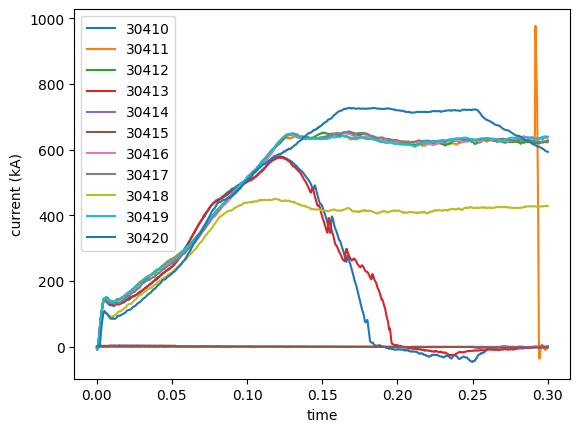

In [143]:
for current in plasma_shots:
    plt.plot(current.timesec, current.data, label=current.attrs['shot_id'])
    plt.xlabel('time')
    plt.ylabel(f"current ({current.attrs['units']})")

plt.legend()

## Larger Data - Loading RBA Image Data

In this example we show how to load Image data remotely. Image data are just grouped by source, such as the `rba` data. In this example we load all the image data from an `rba` group and create a GIF of the contents.

In [134]:
dataset = catalog.shots(url=shot.url, group='rbb')
dataset = dataset.read()
dataset

<xarray.Dataset> Size: 94MB
Dimensions:  (time: 329, height: 448, width: 640)
Coordinates:
  * time     (time) float64 3kB 1.6e-05 0.002016 0.004016 ... 0.352 0.354 0.356
Dimensions without coordinates: height, width
Data variables:
    data     (time, height, width) uint8 94MB 0 0 2 0 0 0 3 4 ... 2 2 4 0 0 0 0
Attributes: (12/48)
    CLASS:           IMAGE
    IMAGE_SUBCLASS:  IMAGE_INDEXED
    IMAGE_VERSION:   1.2
    board_temp:      0.0
    bottom:          680
    camera:          
    ...              ...
    units:           pixels
    uuid:            36b9c4e7-d459-54c3-afb7-9b299d8f532a
    vbin:            0
    version:         -1
    view:            photron HM10 + Dalpha filter
    width:           640

In [136]:
imgs = [PIL.Image.fromarray(img) for img in dataset.data.values]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)
Image(url='array.gif') 